In [9]:
%load_ext autoreload
%autoreload 2

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from tqdm import tqdm
from scipy.stats import pearsonr
from collections import defaultdict
import gseapy as gp
import anndata
from scipy import stats
from eval_utils import *
from plot_utils import *
sns.set_style('whitegrid')

In [31]:
outdir = '../results'
figdir = f'{outdir}/overleaf/figures'
dataset = 'Adamson2016'
seeds = [1, 2, 3]
methods = ['cpa', 'gears', 'scgpt', 'nonctl-mean', 'matching-mean']

In [8]:
results_df = pd.DataFrame(
    columns=["method", "pert", "seed", "corr_all", "corr_20de", "mse_all", "mse_20de", "jaccard", "one gene", "train"]
)
for seed in seeds:
    file = f'../data/{dataset.lower()}/{dataset.lower()}_{seed}.h5ad'
    adata = anndata.read_h5ad(file)

    # Get control mean, non control mean (pert_mean), and non control mean differential
    train_adata = adata[adata.obs['split'] == 'train']
    control_adata = train_adata[train_adata.obs['control'] == 1]
    pert_adata = train_adata[train_adata.obs['control'] == 0]
    control_mean = np.array(control_adata.X.mean(axis=0))[0]
    pert_mean = np.array(pert_adata.X.mean(axis=0))[0]
    for method in tqdm(methods):
        post_gt_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-gt.csv', index_col=[0, 1])
        post_pred_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-pred.csv', index_col=[0, 1])
        conditions = post_gt_df.index.get_level_values('condition').unique()
        for condition in conditions:
            gene_list = condition.split("+")
            one_gene = False
            if "ctrl" in gene_list:
                gene_list.remove("ctrl")
                one_gene = True
            one_gene_str = "1-gene" if one_gene else "2-gene"

            # Get data
            X_true = post_gt_df.loc[condition].values[0]
            X_pred = post_pred_df.loc[condition].values[0]
            delta_true = X_true - control_mean
            delta_pred = X_pred - control_mean
            n_train = post_gt_df.loc[condition].index.get_level_values('n_train').values[0]

            # Get top 20 DE genes
            adata_condition = adata[adata.obs["condition"] == condition]

            # Select top 20 DE genes
            top20_de_genes = adata.uns["top_non_dropout_de_20"][
                adata_condition.obs["condition_name"].values[0]
            ]
            top20_de_idxs = np.argwhere(
                np.isin(adata.var.index, top20_de_genes)
            ).ravel()

            # Jaccard similarity
            top20_de_idxs_pred = get_topk_de_gene_ids(control_mean, X_pred, k=20)
            
            # Store results
            results_df.loc[len(results_df)] = [
                    method,
                    condition,
                    seed,
                    pearsonr(delta_true, delta_pred)[0],
                    pearsonr(delta_true[top20_de_idxs], delta_pred[top20_de_idxs])[0],
                    np.mean((delta_true - delta_pred)**2),
                    np.mean((delta_true[top20_de_idxs] - delta_pred[top20_de_idxs])**2),
                    jaccard_similarity(top20_de_idxs, top20_de_idxs_pred),
                    one_gene_str,
                    n_train,
                ]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.06it/s]


#### Combined figure

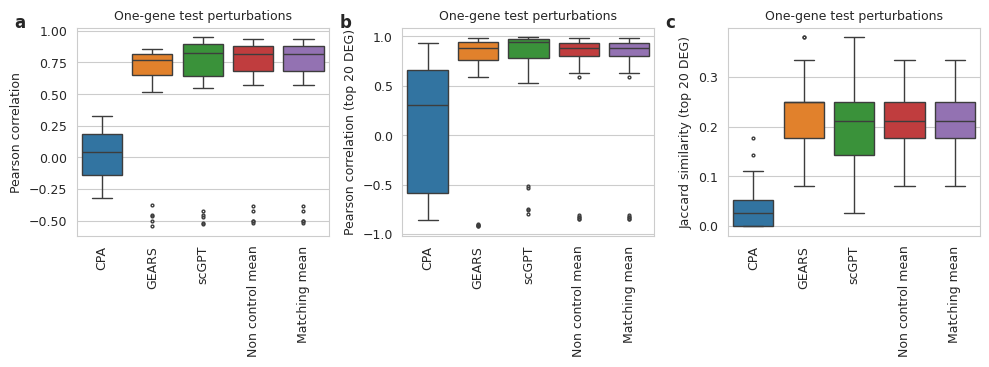

In [32]:
nrows = 2
ncols = 3
fontsize = 9
fliersize = 2
labels=['CPA', 'GEARS', 'scGPT', 'Non control mean', 'Matching mean']
fig = plt.figure(figsize=(10, 6))
plt.subplot(nrows, ncols, 1)
letter_annotation(plt.gca(), -.25, 1, 'a')
sns.boxplot(data=results_df, x='method', y='corr_all', hue='method',
            fliersize=fliersize,
            order=methods)
plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('');

plt.subplot(nrows, ncols, 2)
letter_annotation(plt.gca(), -.25, 1, 'b')
sns.boxplot(data=results_df, y='corr_20de', x='method', hue='method',
            order=methods,
            fliersize=fliersize)
plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('');

plt.subplot(nrows, ncols, 3)
letter_annotation(plt.gca(), -.25, 1, 'c')
sns.boxplot(data=results_df, y='jaccard', x='method', hue='method',
            order=methods,
            fliersize=fliersize)
plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('');
# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# handles, labels = plt.gca().get_legend_handles_labels()
# legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.07), fancybox=True, shadow=True, ncol=5)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig(f'{figdir}/{dataset}_pearsondiff_combined.pdf', bbox_inches='tight');

#### Combined MSE figure

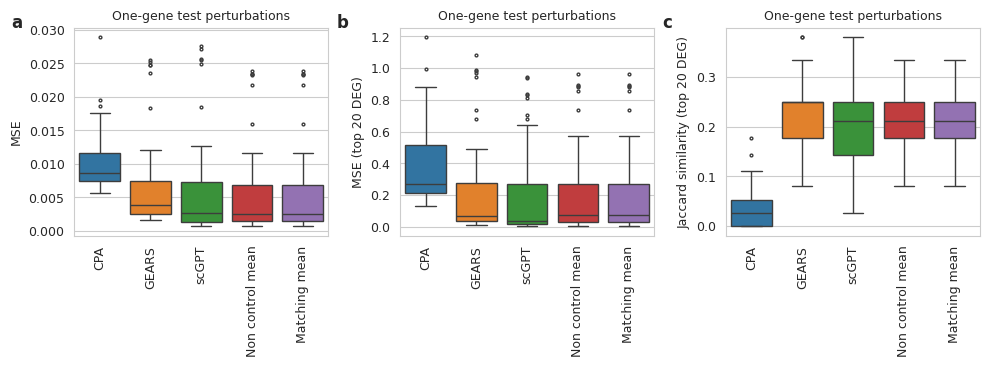

In [33]:
nrows = 2
ncols = 3
fontsize = 9
fliersize = 2
labels=['CPA', 'GEARS', 'scGPT', 'Non control mean', 'Matching mean']
fig = plt.figure(figsize=(10, 6))
plt.subplot(nrows, ncols, 1)
letter_annotation(plt.gca(), -.25, 1, 'a')
sns.boxplot(data=results_df, x='method', y='mse_all', hue='method',
            fliersize=fliersize,
            order=methods)
plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One-gene test perturbations', fontsize=fontsize)
plt.ylabel('MSE', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('');

plt.subplot(nrows, ncols, 2)
letter_annotation(plt.gca(), -.25, 1, 'b')
sns.boxplot(data=results_df, y='mse_20de', x='method', hue='method',
            order=methods,
            fliersize=fliersize)
plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One-gene test perturbations', fontsize=fontsize)
plt.ylabel('MSE (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('');

plt.subplot(nrows, ncols, 3)
letter_annotation(plt.gca(), -.25, 1, 'c')
sns.boxplot(data=results_df, y='jaccard', x='method', hue='method',
            order=methods,
            fliersize=fliersize)
plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('');
# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# handles, labels = plt.gca().get_legend_handles_labels()
# legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.07), fancybox=True, shadow=True, ncol=5)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig(f'{figdir}/{dataset}_msediff_combined.pdf', bbox_inches='tight');